In [1]:
import pandas as pd

# MODULES

Gene modules are genes that show co-expression across cells in the dataset ( TF + gene). 

The strenght of that co-expression is measured by the column "importance"

In [2]:
module = pd.read_table("/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/Networks/ER_network.tsv", sep = "\t")

In [3]:
print(f"Nº of modules {module.shape[0]}")

Nº of modules 1317005


Perform minimalistic filtering at first. 

In [4]:
module_fil = module[module.importance > module.importance.quantile(0.25)].copy()

In [5]:
print(f"Nº of modules after initial filtering {module_fil.shape[0]}") 

Nº of modules after initial filtering 987753


# REGULONS

Regulons are sets of genes which share regulatory sequences to which a certain TF binds to. 


In [71]:
from pyscenic.utils import load_motifs

In [87]:
motifs = load_motifs("/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/regulones/ER_regulons.csv")

In [37]:
def contains(*elems):
    def f(context):
        return any(elem in context for elem in elems)
    return f

In [38]:
import numpy as np
from cytoolz import compose
import operator as op
import os
from os import listdir

In [39]:
databases_directory = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/Common_files/databases"
cis_target_data = {}
for file in listdir(databases_directory):
    if file.endswith(".feather"):
        cis_target_data[file] = pd.read_feather(os.path.join(databases_directory,file))  

databases_names = list(cis_target_data.keys())
databases_names = [os.path.splitext(filename)[0] for filename in databases_names] 

In [88]:
def derive_regulons(motifs, db_names=databases_names):
    motifs.columns = motifs.columns.droplevel(0)

    def contains(*elems):
        def f(context):
            return any(elem in context for elem in elems)
        return f

    # For the creation of regulons we only keep the 10-species databases and the activating modules. We also remove the
    # enriched motifs for the modules that were created using the method 'weight>50.0%' (because these modules are not part
    # of the default settings of modules_from_adjacencies anymore.
    motifs = motifs[
        np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
        np.fromiter(map(contains('activating'), motifs.Context), dtype=np.bool)]

    # We build regulons only using enriched motifs with a NES of 3.0 or higher; we take only directly annotated TFs or TF annotated
    # for an orthologous gene into account; and we only keep regulons with at least 10 genes.
    regulons = list(filter(lambda r: len(r) >= 10, df2regulons(motifs[(motifs['NES'] >= 3.0) 
                                                                      & ((motifs['Annotation'] == 'gene is directly annotated')
                                                                        | (motifs['Annotation'].str.startswith('gene is orthologous to')
                                                                           & motifs['Annotation'].str.endswith('which is directly annotated for motif')))
                                                                     ])))
    
    # Rename regulons, i.e. remove suffix.
    return list(map(lambda r: r.rename(r.transcription_factor), regulons))


In [89]:
from pyscenic.transform import df2regulons

In [90]:
regulons = derive_regulons(motifs)

/tmp/ipykernel_272746/2029404592.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(compose(op.not_, contains('weight>50.0%')), motifs.Context), dtype=np.bool) & \
/tmp/ipykernel_272746/2029404592.py:14: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.fromiter(map(contains(*db_names), motifs.Context), dtype=np.bool) & \
/tmp/ipyk

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [93]:
import json
import zlib
import base64
import loompy as lp
import pandas as pd
f_pyscenic_output = "/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/grn/aucell/ER_aucell.loom"
# collect SCENIC AUCell output
lf = lp.connect(f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

/opt/venv/lib/python3.10/site-packages/loompy/view_manager.py:23: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if type(slice_) is not tuple or len(slice_) is not 2:


In [94]:
auc_mtx

,ALX3(+),AR(+),ARID5B(+),ASCL1(+),ATF3(+),ATF4(+),ATF5(+),BACH1(+),BATF(+),BCL11A(+),...,ZNF432(+),ZNF444(+),ZNF580(+),ZNF627(+),ZNF662(+),ZNF704(+),ZNF791(+),ZNF841(+),ZNF91(+),ZSCAN31(+)
AAACCCAAGGACGGAG-1-MH0151-,0.000000,0.000000,0.115301,0.042699,0.097610,0.133261,0.035680,0.000564,0.031093,0.068606,...,0.000000,0.000000,0.037747,0.0,0.0,0.0,0.031630,0.022124,0.0,0.000000
AAACCCACAGCGTTTA-1-MH0151-,0.000176,0.000000,0.061530,0.011726,0.038562,0.072885,0.023172,0.066155,0.002392,0.026460,...,0.121820,0.000000,0.026396,0.0,0.0,0.0,0.076258,0.000000,0.0,0.000000
AAACCCAGTATCAAGA-1-MH0151-,0.000000,0.025392,0.059641,0.014325,0.090809,0.115962,0.019358,0.003340,0.000000,0.023385,...,0.000000,0.117533,0.060262,0.0,0.0,0.0,0.051092,0.000000,0.0,0.033877
AAACGAAAGACCAACG-1-MH0151-,0.000000,0.003117,0.042772,0.000000,0.073154,0.117351,0.037988,0.000000,0.000000,0.052102,...,0.000000,0.005531,0.077553,0.0,0.0,0.0,0.030282,0.000000,0.0,0.000000
AAACGAAGTCGAACGA-1-MH0151-,0.000000,0.000000,0.047063,0.003374,0.046009,0.081346,0.133690,0.079971,0.059436,0.022699,...,0.000000,0.217920,0.034564,0.0,0.0,0.0,0.021536,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGCAGGGTCTC-1-MH0167-T-,0.000192,0.000000,0.056616,0.011836,0.049449,0.078151,0.032202,0.048152,0.002511,0.036438,...,0.019497,0.000000,0.096375,0.0,0.0,0.0,0.093024,0.000000,0.0,0.000000
TTTGTTGGTGACTCGC-1-MH0167-T-,0.008834,0.012520,0.052954,0.037666,0.049368,0.111181,0.027666,0.006529,0.000000,0.043097,...,0.000000,0.000000,0.063376,0.0,0.0,0.0,0.028519,0.000000,0.0,0.010924
TTTGTTGGTTCTATCT-1-MH0167-T-,0.000000,0.030119,0.074961,0.049723,0.047243,0.063653,0.048965,0.000000,0.019702,0.025752,...,0.080476,0.000000,0.082624,0.0,0.0,0.0,0.029936,0.030378,0.0,0.000000
TTTGTTGTCGCAATTG-1-MH0167-T-,0.000000,0.005883,0.068264,0.000000,0.057311,0.100493,0.043679,0.000000,0.000000,0.037699,...,0.000000,0.010785,0.080446,0.0,0.0,0.0,0.000000,0.048417,0.0,0.020326


In [96]:
import scanpy as sc

In [97]:
adata = sc.read_h5ad("/home/igarzonalva/Proyecto_SC_TNBC/GSE161529/Integration/adata/adata_scanvi_predictions.h5ad")

In [101]:
adata_ER = adata[adata.obs['subtype'] == 'ER',:].copy()

In [95]:
from pyscenic.export import export2loom, add_scenic_metadata

In [102]:
add_scenic_metadata(adata_ER, auc_mtx, regulons)

AnnData object with n_obs × n_vars = 61800 × 18088
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'complexity', 'doublet_scores', 'predicted_doublets', 'n_genes', 'n_counts', 'celltypist_labels_Immune_All_High', 'celltypist_scores_Immune_All_High', 'celltypist_labels_Cells_Adult_Breast', 'celltypist_scores_Cells_Adult_Breast', 'batch', 'subtype', 'leiden', 'GenAnno', 'cell_type', 'predicted_labels', 'Regulon(ALX3(+))', 'Regulon(AR(+))', 'Regulon(ARID5B(+))', 'Regulon(ASCL1(+))', 'Regulon(ATF3(+))', 'Regulon(ATF4(+))', 'Regulon(ATF5(+))', 'Regulon(BACH1(+))', 'Regulon(BATF(+))', 'Regulon(BCL11A(+))', 'Regulon(BCL11B(+))', 'Regulon(BCL6(+))', 'Regulon(BCL6B(+))', 'Regulon(BHLHE41(+))', 'Regulon(BPTF(+))', 'Regulon(CEBPA(+))', 'Regulon(CEBPB(+))', 'Regulon(CEBPD(+))', 'Regulon(CEBPG(+))', 'Regulon(CLOCK(+))', 'Regulon(CREB1

In [173]:
df_obs = adata_ER.obs
signature_column_names = list(df_obs.select_dtypes('number').columns)
signature_column_names = list(filter(lambda s: s.startswith('Regulon('), signature_column_names))
df_scores = df_obs[signature_column_names + ['cell_type']]
df_results = ((df_scores.groupby(by='cell_type').mean() - df_obs[signature_column_names].mean())/ df_obs[signature_column_names].std()).stack().reset_index().rename(columns={'level_1': 'regulon', 0:'Z'})
df_results['regulon'] = list(map(lambda s: s[8:-1], df_results.regulon))
df_results[(df_results.Z >= 3.0)].sort_values('Z', ascending=False).head()

,cell_type,regulon,Z
2307,MastCells,GATA2(+),11.774242
2461,MastCells,TAL1(+),9.564133
2562,Endothelial,ERG(+),7.103243
2721,Endothelial,SOX17(+),6.595128
2596,Endothelial,HEY1(+),6.302975


In [179]:
df_results[df_results.cell_type == "CyclingEpithelial"].sort_values("Z", ascending = False)

,cell_type,regulon,Z
1743,CyclingEpithelial,FOXM1(+),2.041434
1707,CyclingEpithelial,E2F1(+),2.000167
1710,CyclingEpithelial,E2F8(+),1.987102
1828,CyclingEpithelial,MYBL2(+),1.955102
1708,CyclingEpithelial,E2F2(+),1.872465
...,...,...,...
1797,CyclingEpithelial,KLF2(+),-0.682979
1808,CyclingEpithelial,MAF(+),-0.700498
1802,CyclingEpithelial,KLF9(+),-0.706927
1927,CyclingEpithelial,ZBTB20(+),-0.794493


In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(95.72222222222221, 0.5, '')

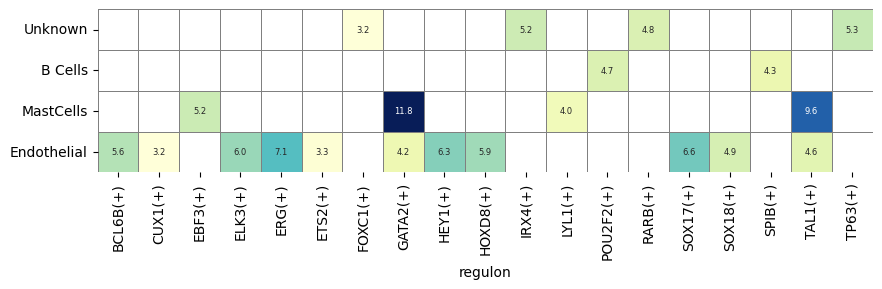

In [112]:
df_heatmap = pd.pivot_table(data=df_results[df_results.Z >= 3.0].sort_values('Z', ascending=False),
                           index='cell_type', columns='regulon', values='Z')
#df_heatmap.drop(index='Myocyte', inplace=True) # We leave out Myocyte because many TFs are highly enriched (becuase of small number of cells).
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(df_heatmap, ax=ax1, annot=True, fmt=".1f", linewidths=.7, cbar=False, square=True, linecolor='gray', 
            cmap="YlGnBu", annot_kws={"size": 6})
ax1.set_ylabel('')

In [114]:
from pyscenic.rss import regulon_specificity_scores

In [115]:
rss = regulon_specificity_scores(auc_mtx, adata_ER.obs.cell_type)


In [116]:
rss

,ALX3(+),AR(+),ARID5B(+),ASCL1(+),ATF3(+),ATF4(+),ATF5(+),BACH1(+),BATF(+),BCL11A(+),...,ZNF432(+),ZNF444(+),ZNF580(+),ZNF627(+),ZNF662(+),ZNF704(+),ZNF791(+),ZNF841(+),ZNF91(+),ZSCAN31(+)
Fibroblasts,0.244017,0.233277,0.310294,0.282869,0.259857,0.256779,0.254584,0.323069,0.255751,0.290064,...,0.236788,0.221480,0.252926,0.188939,0.184903,0.247301,0.261320,0.198998,0.202023,0.194664
TCells,0.239034,0.225897,0.284887,0.229218,0.262466,0.262341,0.248327,0.317247,0.275053,0.270945,...,0.289389,0.225542,0.242889,0.210629,0.168721,0.210200,0.287102,0.219446,0.196313,0.197479
Epithelial,0.309528,0.462511,0.541365,0.393548,0.593827,0.598498,0.499759,0.330076,0.465490,0.532313,...,0.298986,0.387727,0.619060,0.220731,0.177802,0.314965,0.509363,0.250739,0.256880,0.324976
Myeloid,0.191995,0.228650,0.255852,0.227161,0.259727,0.251710,0.404116,0.393732,0.223757,0.263980,...,0.221491,0.215522,0.244007,0.185000,0.168117,0.202723,0.244648,0.208994,0.207153,0.196194
Endothelial,0.208992,0.190544,0.193297,0.183914,0.187511,0.185865,0.186613,0.199521,0.185187,0.187721,...,0.185569,0.177802,0.184133,0.179244,0.204807,0.178496,0.191529,0.178933,0.187889,0.178428
B Cells,0.175639,0.180290,0.185122,0.175051,0.183117,0.183263,0.183189,0.194791,0.185631,0.192660,...,0.184772,0.176871,0.178629,0.179093,0.167445,0.174057,0.187569,0.175431,0.174870,0.175556
MastCells,0.169864,0.170884,0.173038,0.170586,0.172562,0.172287,0.172483,0.175570,0.170575,0.172337,...,0.172677,0.171424,0.171117,0.171627,0.167445,0.171629,0.173051,0.174442,0.171125,0.168387
Unknown,0.192000,0.189761,0.209731,0.190912,0.204246,0.201197,0.194292,0.194127,0.193178,0.226644,...,0.190315,0.192095,0.194448,0.178323,0.191624,0.193683,0.192652,0.177294,0.182001,0.177241
CyclingEpithelial,0.207512,0.224089,0.249446,0.240330,0.254005,0.269816,0.245079,0.197899,0.221413,0.244322,...,0.203647,0.220415,0.269607,0.192244,0.170519,0.218401,0.237508,0.200180,0.203896,0.221150
PlasmaCells,0.173269,0.172222,0.175408,0.170727,0.175249,0.175376,0.174113,0.176569,0.174130,0.177563,...,0.175363,0.174628,0.174361,0.174744,0.167445,0.174262,0.174963,0.172012,0.171176,0.177409


In [140]:
adata.obs['cell_type'].cat.categories

Index(['Myeloid', 'Unknown', 'Fibroblasts', 'B Cells', 'Epithelial',
       'PlasmaCells', 'CyclingEpithelial', 'TCells', 'MastCells',
       'Endothelial'],
      dtype='object')

In [126]:
from pyscenic.plotting import plot_binarization, plot_rss

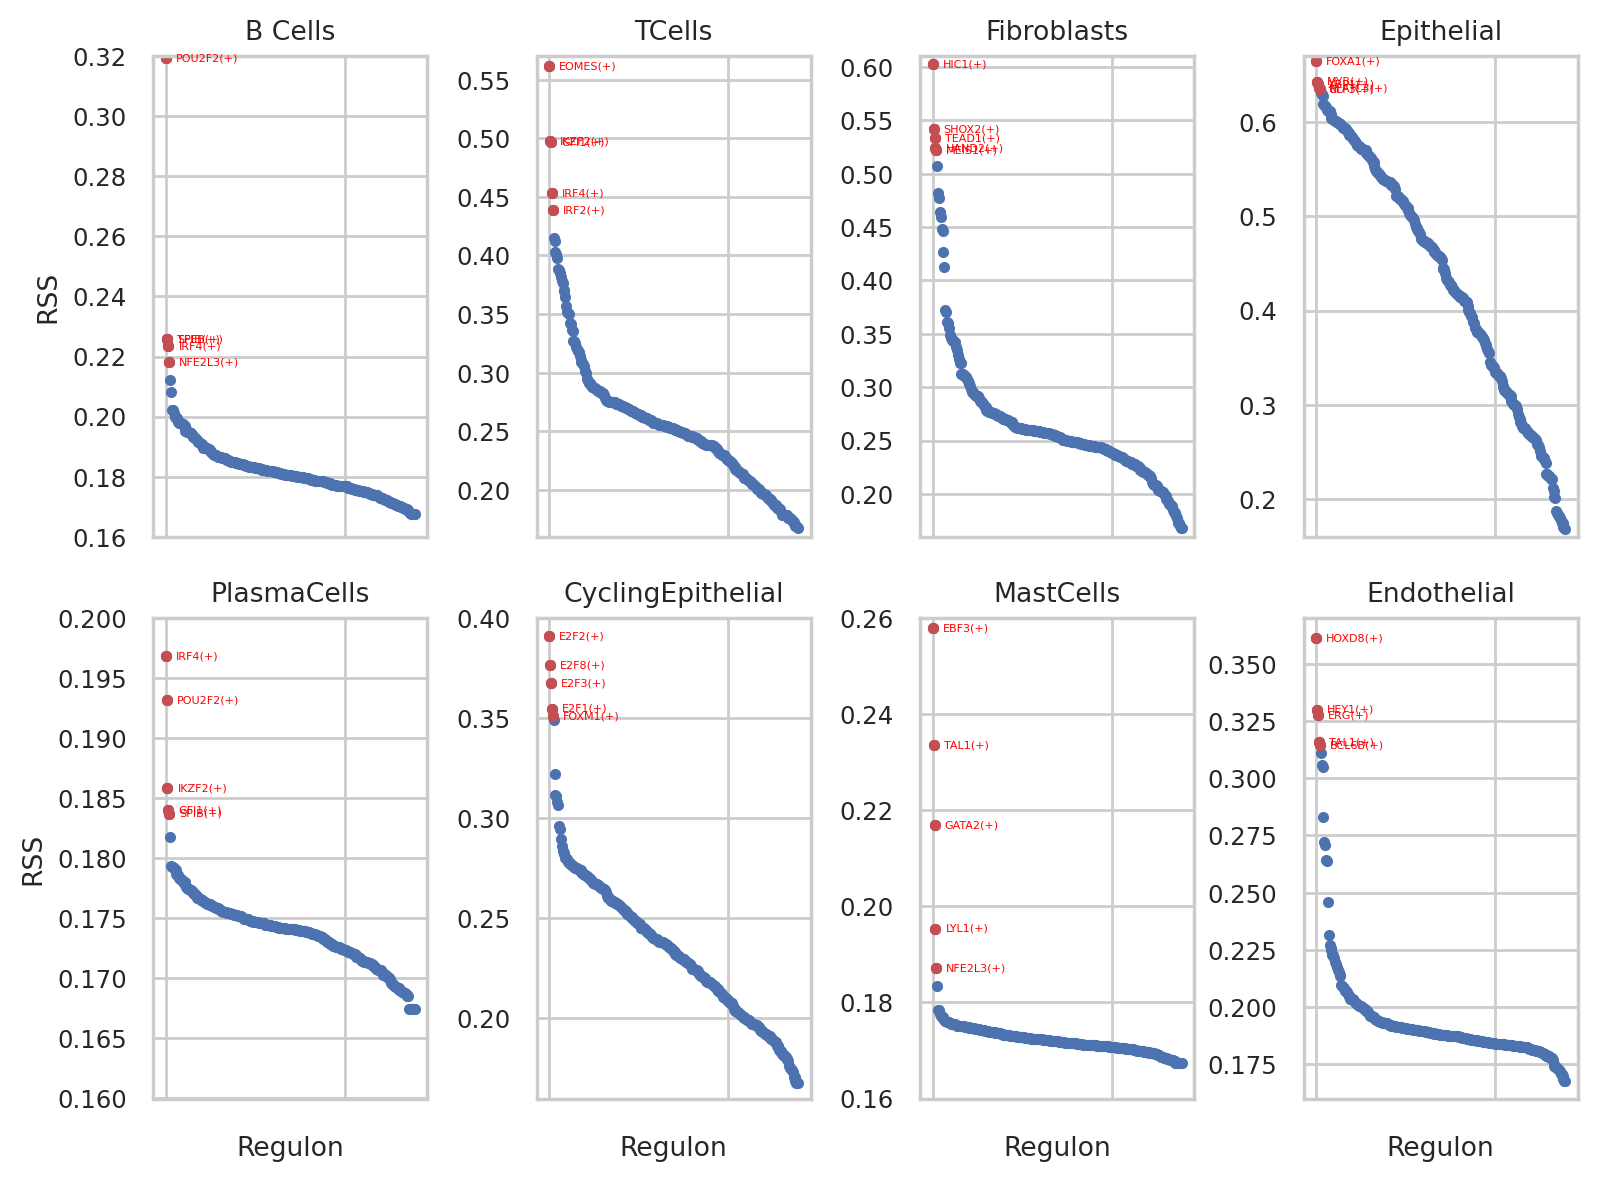

In [143]:
sns.set()
sns.set(style='whitegrid', font_scale=0.8)
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(8, 6), dpi=100)
plot_rss(rss, 'B Cells', ax=ax1)
ax1.set_xlabel('')
plot_rss(rss, 'TCells', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('')
plot_rss(rss, 'Fibroblasts', ax=ax3)
ax3.set_xlabel('')
ax3.set_ylabel('')
plot_rss(rss, 'Epithelial', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('')
plot_rss(rss, 'PlasmaCells', ax=ax5)
plot_rss(rss, 'CyclingEpithelial', ax=ax6)
ax6.set_ylabel('')
plot_rss(rss, 'MastCells', ax=ax7)
ax7.set_ylabel('')
plot_rss(rss, 'Endothelial', ax=ax8)
ax8.set_ylabel('')
plt.tight_layout()

/opt/venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


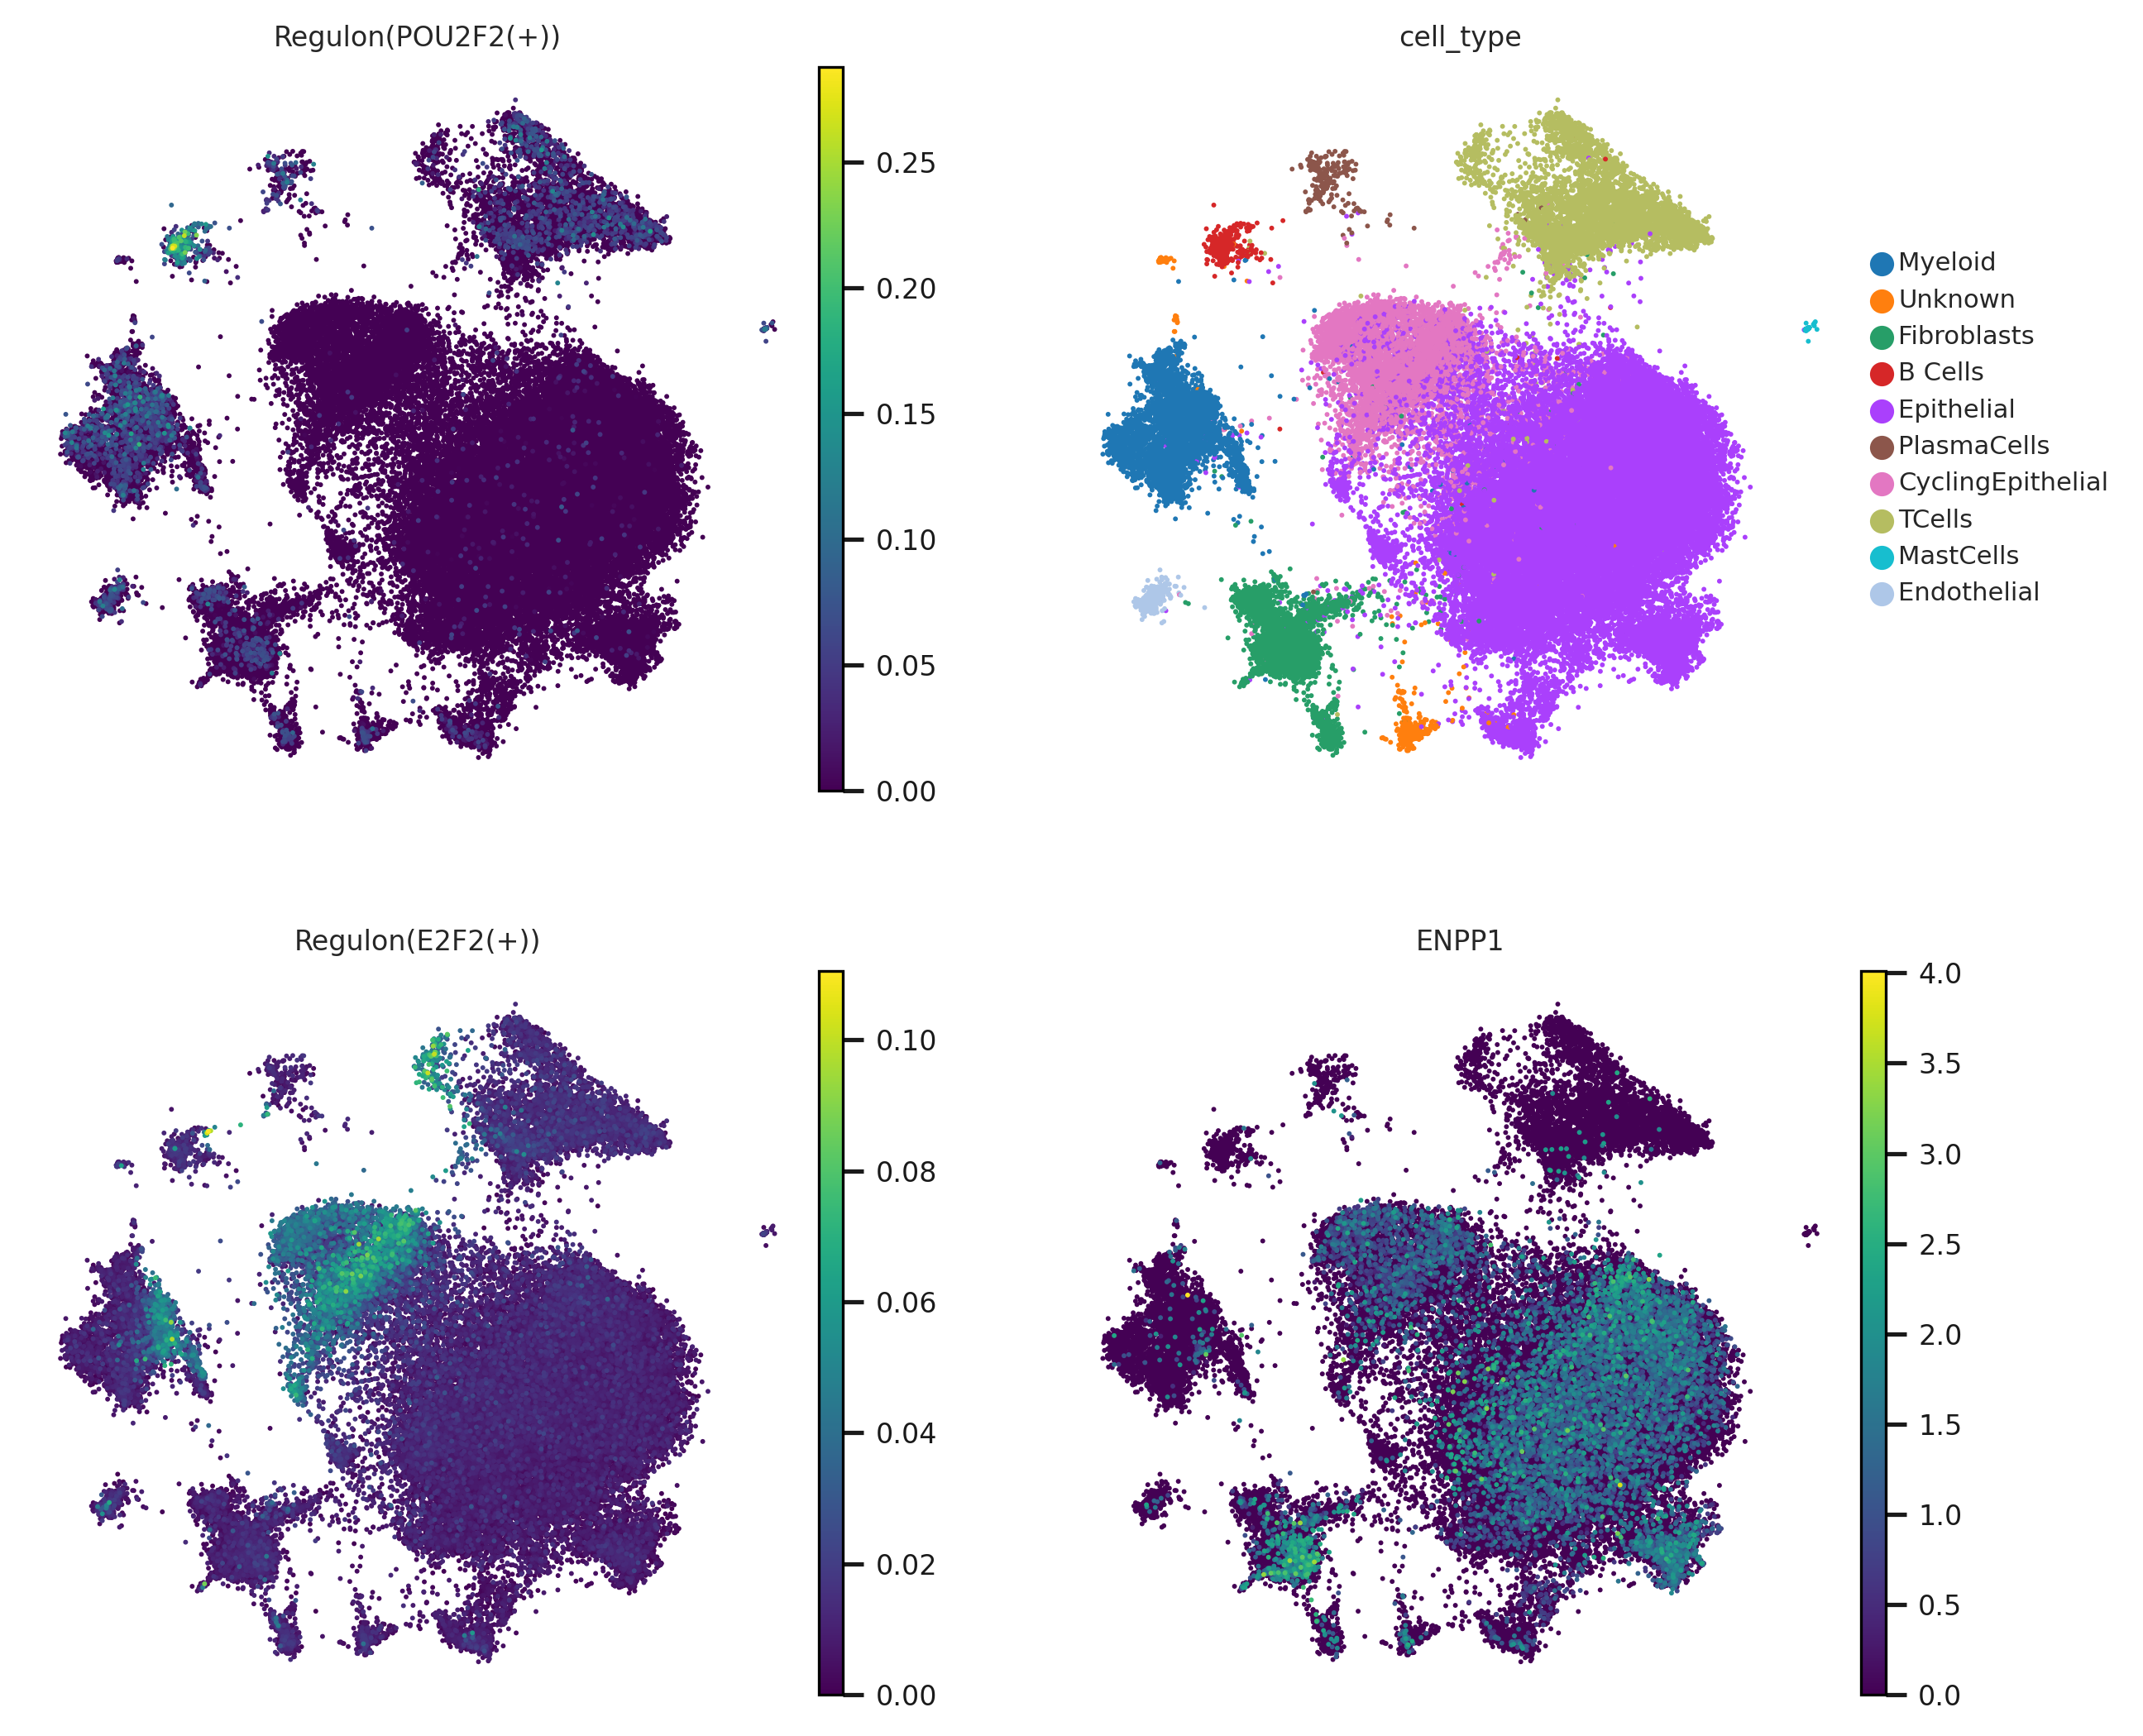

In [155]:
sc.set_figure_params(frameon=False, dpi=150, fontsize=8)
sc.pl.embedding(
    adata_ER,
    basis="X_scanvi_MDE",
    color=["Regulon(POU2F2(+))","cell_type", "Regulon(E2F2(+))", "ENPP1"],
    frameon=False,
    ncols=2,use_raw = False, cmap = "viridis", size = 8)